In [472]:
import cv2
import numpy as np
from queue import PriorityQueue
import matplotlib.pyplot as plt
%matplotlib inline  
%autosave 120
try:
    import sim
except:
    print ('--------------------------------------------------------------')
    print ('Houve um erro ao erro ao importar o CoppeliaSim ')
    print ('--------------------------------------------------------------')
    print ('')

import time
from IPython.display import clear_output
from IPython.display import display
import ctypes 

Autosaving every 120 seconds


## Carrega e salva a imagem

Leitura da imagem usando opencv:

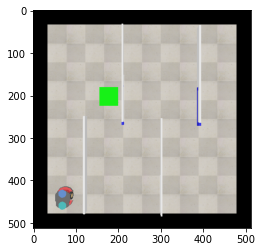

In [473]:
img = cv2.imread("grid_with_orientation.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
%matplotlib inline
plt.imshow(img)
plt.show()

## Grade de obstáculos

Grade de obstáculos é gerada de forma que onde o robô pode passar tem valor 1 e onde há obstáculos tem valor 0. 


In [474]:
def obstacles_grid(img):
    # getting the walls 
    mask_wall = cv2.inRange(img, np.array([230,230,230]),np.array([240,240,240]))
    # getting the rims
    mask_rim = cv2.inRange(img, 0, 0)
    mask_total = cv2.bitwise_or(mask_wall,mask_rim,mask_rim)
    mask_total = cv2.bitwise_not(mask_total)
    return mask_total

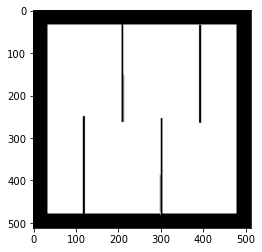

In [475]:
img_obs = obstacles_grid(img)
%matplotlib inline
plt.imshow(img_obs, cmap="gray")
plt.show()

## Posição e orientação do robô
A orientação do robô é feita através dos dois discos de cores diferentes que foram colocados nele 

In [476]:
def get_front_disk_position (img):
    front_disk_mask = cv2.inRange(img, np.array([100,140,205]), np.array([105,145,210]))
    contours, hierarchy = cv2.findContours(front_disk_mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    #no need for the for loop but it is used to avoid errors
    for c in contours:
        # compute the center of the contour
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    return np.array([cY,cX])

def get_back_disk_position (img):
    rear_disk_mask = cv2.inRange(img, np.array([75,185,185]), np.array([80,190,190]))    
    #im2, contours, hierarchy = cv2.findContours(rear_disk_mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contours, hierarchy = cv2.findContours(rear_disk_mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    #no need for the for loop but it is used to avoid errors
    for c in contours:
        # compute the center of the contour
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    return np.array([cY,cX])
def get_robot_orientation(img):
    front_disk_position = get_front_disk_position(img)
    rear_disk_position =  get_back_disk_position(img)
    orientation = np.arctan2(rear_disk_position[1]-front_disk_position[1] , rear_disk_position[0]-front_disk_position[0])
    return orientation

In [477]:
orient = get_robot_orientation(img)
print(orient)

0.0


In [478]:
def get_robot_position(img):
    front_disk_position = get_front_disk_position (img)
    rear_disk_position =  get_back_disk_position (img)
    robot_pos = (front_disk_position+rear_disk_position)/2
    return tuple(robot_pos.astype('int'))

(445, 68)


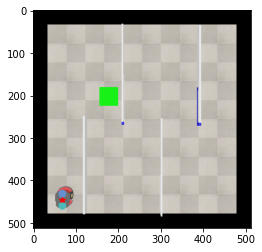

In [479]:
center_robot = get_robot_position(img)
print(center_robot)
%matplotlib inline
plt.imshow(img)
plt.plot(center_robot[1],center_robot[0], "*r")
plt.show()

## Goal Position

In [480]:
def get_goal_position(img):
    goal_mask = cv2.inRange(img[:,:,1], 240, 255)
    goal_mask = cv2.GaussianBlur(goal_mask, (9, 9), 0)
    contours, hierarchy = cv2.findContours(goal_mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    #no need for the for loop but it is used to avoid errors
    for c in contours:
        # compute the center of the contour
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

    return goal_mask, (cY,cX)

(202, 177)


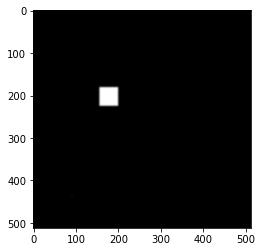

In [481]:
img_goal, center_goal = get_goal_position(img)
print(center_goal)
%matplotlib inline
plt.imshow(img_goal, cmap="gray")
plt.show()

## O algorítmo astar


In [482]:
def search(grid,init,goal,cost, D = 1, fnc='Euclidean', D2 = 1):
    
    def Euclidean_fnc(current_indx, goal_indx,D = 1):
        return np.sqrt( ( (current_indx[0]-goal_indx[0])**2 + (current_indx[1]-goal_indx[1])**2 ) )
    def Manhattan_fnc(current_indx, goal_indx,D = 1):
        dx = np.sqrt((current_indx[0]-goal_indx[0])**2)
        dy = np.sqrt((current_indx[1]-goal_indx[1])**2)
        return D * (dx + dy)
    def Diagonal_fnc(current_indx, goal_indx,D = 1):
        dx = np.sqrt((current_indx[0]-goal_indx[0])**2)
        dy = np.sqrt((current_indx[1]-goal_indx[1])**2)
        return D * (dx + dy) + (D2 - 2 * D) * min(dx, dy) 
    
    if fnc=='Euclidean':
        hueristic_fnc = Euclidean_fnc
    elif fnc == "Manhattan":
        hueristic_fnc = Manhattan_fnc
    elif fnc == "Diagonal" :
        hueristic_fnc = Diagonal_fnc
    
    
    def near_obstacles(point, half_kernel = 5):
        x_start = int(max(point[0] - half_kernel, 0))
        x_end = int(min(point[0] + half_kernel, grid.shape[0]))
        y_start = int(max(point[1] - half_kernel, 0))
        y_end = int(min(point[1] + half_kernel, grid.shape[1]))
        return np.any(grid[x_start:x_end, y_start:y_end]<128)
    
    def delta_gain(gain = 1):
        delta = np.array([[-1, 0], # go up
                          [-1,-1], # up left
                          [ 0,-1], # go left
                          [ 1,-1], # down left
                          [ 1, 0], # go down
                          [ 1, 1],  # down right
                          [ 0, 1], # go right         
                          [-1, 1] # up right         
         ]) 
        return delta*gain
    
    delta = delta_gain(gain = 5)
    front = PriorityQueue()
    G = 0
    H = hueristic_fnc(init, goal, D)
    F = G+H
    front.put((F, G, init))
    discovered = []
    discovered.append(init)
    
    actions = np.ones_like(grid)*-1
    count = 0
    path = []
    
    def policy_draw(indx):
        indx_old = tuple(indx)
        indx_new = tuple(indx)
        path.append(tuple(goal))
        while indx_new != init:
            indx_new = tuple( np.array(indx_old) - delta[int(actions[indx_old])] )
            path.append(indx_new)
            indx_old = indx_new
    
        
    while not front.empty() :
        front_element = front.get()
        G = front_element[1]
        indx = front_element[2]
        if ((indx[0] >= goal[0]-20) and (indx[0] < goal[0]+20)) and ((indx[1] >= goal[1]-20) and (indx[1] < goal[1]+20)):
            policy_draw(indx)
            print("found goal")
            print(count)
            print(front_element)
            break 
        else:
            for y in range(len(delta)) :
                indx_new = tuple(indx + delta[y])
                if ((np.any(np.array(indx_new) < 0)) or (indx_new[0] > grid.shape[0]-1) or (indx_new[1] > grid.shape[1]-1)) :
                    continue
                if (grid[indx_new] >= 128) and (indx_new not in  discovered) :
                    count += 1
                    # if the obstacle is inside the robot :D, have a really high cost
                    if near_obstacles(indx_new, half_kernel = 35):
                        g_new = G + 1500*cost
                    # if the obstacle is about a robot's length near it , have a high cost
                    elif near_obstacles(indx_new, half_kernel = 70):
                        g_new = G + 15*cost
                    # as before
                    elif near_obstacles(indx_new, half_kernel = 100):
                        g_new = G + 10*cost
                    # as before
                    elif near_obstacles(indx_new, half_kernel = 110):
                        g_new = G + 5*cost
                    else:
                        g_new = G + cost
                    #trying to increase the cost of rapidly changing direction
                    if y == actions[indx]:
                        g_new = g_new 
                    elif (y-1)%len(delta) == actions[indx] or (y+1)%len(delta) == actions[indx]:
                        g_new = g_new + 5*cost
                    else :
                        g_new = g_new + 10*cost
                    h_new = hueristic_fnc(indx_new, goal, D)
                    f_new = (g_new + h_new)-0.0001*count
                    front.put((f_new, g_new, indx_new))
                    discovered.append(indx_new)
                    actions[indx_new] = y        
    else:
        print(count)
        print("fail")                                
    return actions, np.array(path[::-1])

In [483]:
tick = time.time()
actions, path = search(img_obs,center_robot,center_goal,cost = 1, D = 0.5, fnc='Diagonal')
tock = time.time()
print(tock-tick)

found goal
446
(937.9575, 925, (195, 158))
0.13182997703552246


## Path smoothing

In [484]:
def smooth(path,grid, weight_data = 0.5, weight_smooth = 0.1, tolerance = 0.000001, number_of_iter = 1e3):
    newpath = np.copy(path).astype('float64')
    def get_near_obstacles(point, area = 5):
        x_start = int(max(point[0] - area, 0))
        x_end = int(point[0] + area)
        y_start = int(max(point[1] - area, 0))
        y_end = int(point[1] + area)
        points = np.argwhere(grid[x_start:x_end, y_start:y_end]<128)
        points [:,0] += x_start
        points [:,1] += y_start
        if not points.size:
            points = point.copy()
        return points
    
    def near_obstacles(point, half_kernel = 2):
        x_start = int(max(point[0] - half_kernel, 0))
        x_end = int(point[0] + half_kernel)
        y_start = int(max(point[1] - half_kernel, 0))
        y_end = int(point[1] + half_kernel)
        return np.any(grid[x_start:x_end, y_start:y_end]<128)
        
    error = np.ones(path.shape[0])*tolerance+tolerance
    num_points = path.shape[0]
    for count in range(int(number_of_iter)):
        for i in range(1,num_points-1):
            old_val = np.copy(newpath[i])
            update1 = weight_data*(path[i] - newpath[i])
            update2 = weight_smooth*(newpath[i-1]+newpath[i+1]-2*newpath[i])
            newpath[i]+=update1+update2 
            if near_obstacles(newpath[i], half_kernel = 35):
                newpath[i] = old_val
            error[i] = np.abs(np.mean(old_val-newpath[i]))
        if np.mean(error) < tolerance:
            break
    print(count)
    return newpath 

In [485]:
newpath = smooth(path,img_obs, weight_data = 0.1, weight_smooth = 0.6, number_of_iter = 1000)

35


## Plotting everything

In [486]:
%matplotlib inline
fig1 = plt.figure(figsize=(15, 15))  
# plt.imshow(img_obs, cmap="gray")
plt.imshow(img)
plt.plot(path[:,1], path[:,0],'-r')
plt.plot(newpath[:,1], newpath[:,0],'-m')
# plt.plot(yp, xp,'-b')
plt.plot(center_goal[1], center_goal[0], '*b')
plt.plot(center_robot[1], center_robot[0], 'sg')
# plt.plot(newpath[11,1],newpath[11,0], '*r')
plt.show()
fig1.savefig('Astar_smooth_vrep.png', dpi=150)

KeyboardInterrupt: 

## Some helping functions

In [ ]:
#transform from image frame to vrep frame
def transform_points_from_image2real (points):
    if points.ndim < 2:
        flipped = np.flipud(points)
    else:
        flipped = np.fliplr(points)
    scale = 5/445
    points2send = (flipped*-scale) + np.array([2.0555+0.75280899, -2.0500+4.96629213])
    return points2send

In [ ]:
#transform from vrep frame to robot frame
def transform2robot_frame(pos, point, theta):
    pos = np.asarray(pos)
    point = np.asarray(point)
    T_matrix = np.array([
            [np.sin(theta), np.cos(theta)],
            [np.cos(theta), -1*np.sin(theta)],
            ])
    trans = point-pos
    if trans.ndim >= 2:
        trans = trans.T
        point_t = np.dot(T_matrix, trans).T
    else:
        point_t = np.dot(T_matrix, trans)
    return point_t

In [ ]:
def is_near(robot_center, point, dist_thresh = 0.25):
    dist = np.sqrt((robot_center[0]-point[0])**2 + (robot_center[1]-point[1])**2)
    return dist<=dist_thresh

In [ ]:
def get_distance(points1, points2):
    return np.sqrt(np.sum(np.square(points1 - points2), axis=1))

In [ ]:
class pid():
    def __init__(self, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.error = 0.0
        self.error_old = 0.0
        self.error_sum = 0.0
        self.d_error = self.error - self.error_old
    def control(self,error):
        self.error = error
        self.error_sum += error
        self.d_error = self.error - self.error_old
        P = self.kp*self.error
        I = self.ki*self.error_sum
        D = self.kd*self.d_error
        self.error_old = self.error
        return P+I+D    

In [ ]:
def send_path_4_drawing(path, sleep_time = 0.00):
    #the bigger the sleep time the more accurate the points are placed but you have to be very patient :D
    for i in path:
        point2send = transform_points_from_image2real (i)
        packedData=sim.simxPackFloats(point2send.flatten())
        raw_bytes = (ctypes.c_ubyte * len(packedData)).from_buffer_copy(packedData)	
        returnCode=sim.simxWriteStringStream(clientID, "path_coord", raw_bytes, sim.simx_opmode_oneshot)
        time.sleep(sleep_time)
    

## Robot Model
https://chess.eecs.berkeley.edu/eecs149/documentation/differentialDrive.pdf

In [ ]:
d = 0.331 #wheel axis distance
r_w = 0.09751 #wheel radius

In [ ]:
def pioneer_robot_model(v_des, omega_des):
    v_r = (v_des+d*omega_des)
    v_l = (v_des-d*omega_des)
    omega_right = v_r/r_w
    omega_left = v_l/r_w
    return omega_right, omega_left

## Doing everything live

In [ ]:
# find_new_path()
front_range = [3, 4, 5, 6]
front_left_range = [1, 2, 3]
front_right_range = [6, 7, 8]
back_right_range = [9, 10, 11]
back_range = [11, 12, 13, 14]
back_left_range = [14, 15, 16]

detection_state = [False for i in range(17)]
sensor = [False for i in range(17)]
distances = [100 for i in range(17)]
dsnv = [False for i in range(17)]
dp = [False for i in range(17)]
dop = [False for i in range(17)]

distances_to_verify_front_range = [0.1, 0.2, 0.2, 0.1]
# dp - detection point
# doh - detection object handle
# dsnv - detectedSurfaceNormalVector

def verify_error(error, identifier):
    if error == 0:
        return;
    if error == 1:
        print('ERROR: {}: There is no command reply in the input buffer. This should not always be considered as an error, depending on the selected operation mode'.format(identifier))
    elif error == 2:
        print('ERROR: {}: The function timed out (probably the network is down or too slow)'.format(identifier))
    elif error == 4:
        print('ERROR: {}: The specified operation mode is not supported for the given function'.format(identifier))
    elif error == 8:
        print('ERROR: {}: The function caused an error on the server side (e.g. an invalid handle was specified)'.format(identifier))
    elif error == 16:
        print('ERROR: {}: The communication thread is still processing previous split command of the same type'.format(identifier))
    elif error == 32:
        print('ERROR: {}: The function caused an error on the client side'.format(identifier))
    elif error == 64:
        print('ERROR: {}: simxStart was not yet called'.format(identifier))

def measure_distance(arr):
    arr = np.array(arr)
    return np.sqrt(arr.dot(arr))
    
def verify_detection_arr(detection_state, distances):
#     print('collision:', distances)
    for i in range(len(distances)):
        if (distances[i] < distances_to_verify_front_range[i] and detection_state[i] == True):
            return True
    return False

def config_sensors():
    for i in front_range:
        s_str = 'Pioneer_p3dx_ultrasonicSensor{}'.format(i) #sensor str

        res_ultrasonic_handle, sensor[i-1] = sim.simxGetObjectHandle(clientID, s_str , sim.simx_opmode_oneshot_wait)
        verify_error(res_ultrasonic_handle, 'res_ultrasonic_handle')
        res_ultrasonic, detection_state[i-1], dp[i-1], dop[i-1], dsnv[i-1] = sim.simxReadProximitySensor(
            clientID, sensor[i-1], sim.simx_opmode_streaming)
        verify_error(res_ultrasonic, 'res_ultrasonic')
        distances[i-1] = measure_distance(dp[i-1])

def define_direction_to_turn():
    sum_left = measure_distance(dp[3])+measure_distance(dp[4])
    sum_right = measure_distance(dp[5])+measure_distance(dp[6])
    print('l and r', sum_left, sum_right)
    if(sum_left > sum_right):
        return 'left'
    else:
        return 'right'

def verify_front_collision():
    for i in front_range:
        errorCode, detection_state[i-1], dp[i-1], dop[i-1], dsnv[i-1] = sim.simxReadProximitySensor(clientID, sensor[i-1], sim.simx_opmode_buffer)
        distances[i-1] = measure_distance(dp[i-1])
    collision = verify_detection_arr([detection_state[i-1] for i in front_range], [distances[i-1] for i in front_range])
    return collision
        
#         print('dsnv', dsnv)
    # Pioneer.turnLeft()
#         Pioneer.moveForward()
#         time.sleep(0.2)
#         Pioneer.stop()
        
#     Pioneer.stop()
    

## Original

In [ ]:
# lad = 0.5 #look ahead distance
# print ('Starting Connection')
# sim.simxFinish(-1) # just in case, close all opened connections
# clientID=sim.simxStart('127.0.0.1',19997,True,True,5000,5) # Connect to V-REP
# print(clientID)

# if clientID!=-1:
#     print ('Connected to remote API server')  
#     e = sim.simxStartSimulation(clientID,sim.simx_opmode_blocking)
#     print('start',e)
#     try:
#         res,camera0_handle = sim.simxGetObjectHandle(clientID,'top_view_camera',sim.simx_opmode_oneshot_wait)
#         res_l,right_motor_handle = sim.simxGetObjectHandle(clientID,'Pioneer_p3dx_rightMotor',sim.simx_opmode_oneshot_wait)
#         res_r,left_motor_handle = sim.simxGetObjectHandle(clientID,'Pioneer_p3dx_leftMotor',sim.simx_opmode_oneshot_wait)
#         res_las,look_ahead_sphere = sim.simxGetObjectHandle(clientID,'look_ahead',sim.simx_opmode_oneshot_wait)
#         indx = 0
#         err = 10 #to make a knida do while out of while
#         theta = 0.0
#         dt = 0.0
#         count = 0
#         om_sp = 0
#         d_controller   = pid(kp=0.5, ki=0, kd=0)
#         omega_controller = pid(0.5, 0., 0.)
#         while err != sim.simx_return_ok:
#             tick = time.time()
#             errorCode_leftM = sim.simxSetJointTargetVelocity(clientID, left_motor_handle, 0, sim.simx_opmode_oneshot)
#             errorCode_rightM = sim.simxSetJointTargetVelocity(clientID, right_motor_handle,0, sim.simx_opmode_oneshot)
#             err,resolution,image=sim.simxGetVisionSensorImage(clientID,camera0_handle,0,sim.simx_opmode_streaming)  
#             if err == sim.simx_return_ok:
#                 img = np.array(image,dtype=np.uint8)
#                 img.resize([resolution[1],resolution[0],3])
#                 img_obs = obstacles_grid(img)
#                 %matplotlib inline
#                 plt.imshow(img_obs, cmap="gray")
#                 plt.show()
# #                 time.sleep(20)
#                 center_robot = get_robot_position(img)
#                 img_goal, center_goal = get_goal_position(img)
#                 _ , path = search(img_obs,center_robot,center_goal,cost = 1, D = 1 , fnc='Manhattan')
#                 newpath = smooth(path,img_obs, weight_data = 0.1, weight_smooth = 0.65, number_of_iter = 1000)                
#                 path_to_track = transform_points_from_image2real(newpath)
#                 tock = time.time()                
#                 dt = tock - tick
#                 print("planning takes : ", dt)
#                 send_path_4_drawing(newpath, 0.05)
#                 center_goal = transform_points_from_image2real(np.array(center_goal))
#         while not is_near(center_robot, center_goal, dist_thresh = 0.25):            
#             tick = time.time()
#             err,resolution,image=sim.simxGetVisionSensorImage(clientID,camera0_handle,0,sim.simx_opmode_streaming)        
#             if err == sim.simx_return_ok:
#                 img = np.array(image,dtype=np.uint8)
#                 img.resize([resolution[1],resolution[0],3])
#                 center_robot = get_robot_position(img)
#                 center_robot = transform_points_from_image2real(np.array(center_robot))
#                 theta = get_robot_orientation(img)
#                 theta = np.arctan2(np.sin(theta), np.cos(theta))
#                 path_transformed = transform2robot_frame(center_robot, path_to_track, theta)
#                 dist = get_distance(path_transformed, np.array([0,0]))
#                 #loop to determine which point will be the carrot
#                 for i in range(dist.argmin(), dist.shape[0]):
#                     if dist[i] < lad and indx <= i:
#                         indx = i
#                 #mark the carrot with the sphere
#                 returnCode=sim.simxSetObjectPosition(clientID,look_ahead_sphere,-1,(path_to_track[indx,0], path_to_track[indx,1], 0.005),sim.simx_opmode_oneshot)
#                 orient_error = np.arctan2(path_transformed[indx,1], path_transformed[indx,0])
#                 #the controllers 
#                 v_sp = d_controller.control(dist[indx])                     
#                 om_sp =omega_controller.control(orient_error)
#                 vr, vl = pioneer_robot_model(v_sp, om_sp)
#                 errorCode_leftM = sim.simxSetJointTargetVelocity(clientID, left_motor_handle, vr, sim.simx_opmode_oneshot)
#                 errorCode_rightM = sim.simxSetJointTargetVelocity(clientID, right_motor_handle,vl, sim.simx_opmode_oneshot)
#                 count += 1
#                 tock = time.time()                
#                 dt = tock - tick
#                 print(dt)
#         else:
#             print("GOAAAAAAALL !!")
#             errorCode_leftM = sim.simxSetJointTargetVelocity(clientID, left_motor_handle, 0, sim.simx_opmode_oneshot)
#             errorCode_rightM = sim.simxSetJointTargetVelocity(clientID, right_motor_handle,0, sim.simx_opmode_oneshot)
#     finally:
#         errorCode_leftM = sim.simxSetJointTargetVelocity(clientID, left_motor_handle, 0, sim.simx_opmode_oneshot)
#         errorCode_rightM = sim.simxSetJointTargetVelocity(clientID, right_motor_handle,0, sim.simx_opmode_oneshot)
#         time.sleep(0.1)
#         sim.simxStopSimulation(clientID,sim.simx_opmode_blocking)
#         sim.simxFinish(-1)

In [518]:
import sys
sys.path.append("./objects")
from Robot import Robot

sim.simxFinish(-1) # just in case, close all opened connections
clientID = False
lad = 0.5 #look ahead distance
print ('Starting Connection')
if not clientID:
    clientID=sim.simxStart('127.0.0.1',19997,True,True,5000,5) # Connect to V-REP
    print(clientID)
if clientID!=-1:
    print ('Connected to remote API server')  
    e = sim.simxStartSimulation(clientID,sim.simx_opmode_blocking)
    print('start',e)
    config_sensors()
    Pioneer = Robot(clientID)

    
indx = 0
err = 10 #to make a knida do while out of while
theta = 0.0
dt = 0.0
count = 0
om_sp = 0
d_controller   = pid(kp=0.5, ki=0, kd=0)
omega_controller = pid(0.5, 0., 0.)

def define_path(err):
    while err != sim.simx_return_ok:
        tick = time.time()
        errorCode_leftM = sim.simxSetJointTargetVelocity(clientID, left_motor_handle, 0, sim.simx_opmode_oneshot)
        errorCode_rightM = sim.simxSetJointTargetVelocity(clientID, right_motor_handle,0, sim.simx_opmode_oneshot)
        err,resolution,image=sim.simxGetVisionSensorImage(clientID,camera0_handle,0,sim.simx_opmode_streaming)  
        if err == sim.simx_return_ok:
            img = np.array(image,dtype=np.uint8)
            img.resize([resolution[1],resolution[0],3])
            img_obs = obstacles_grid(img)
            center_robot = get_robot_position(img)
            img_goal, center_goal = get_goal_position(img)
            _ , path = search(img_obs,center_robot,center_goal,cost = 1, D = 1 , fnc='Manhattan')
            newpath = smooth(path,img_obs, weight_data = 0.1, weight_smooth = 0.65, number_of_iter = 1000)                
            path_to_track = transform_points_from_image2real(newpath)
            tock = time.time()                
            dt = tock - tick
            print("planning takes : ", dt)
            send_path_4_drawing(newpath, 0.05)
            center_goal = transform_points_from_image2real(np.array(center_goal))
            return center_robot, center_goal, path_to_track

def go(center_robot, center_goal, path_to_track):
    global indx, count
    while not is_near(center_robot, center_goal, dist_thresh = 0.25):
        if(verify_front_collision()):
            break;
        tick = time.time()
        err,resolution,image=sim.simxGetVisionSensorImage(clientID,camera0_handle,0,sim.simx_opmode_streaming)        
        if err == sim.simx_return_ok:
            img = np.array(image,dtype=np.uint8)
            img.resize([resolution[1],resolution[0],3])
            center_robot = get_robot_position(img)
            center_robot = transform_points_from_image2real(np.array(center_robot))
            theta = get_robot_orientation(img)
            theta = np.arctan2(np.sin(theta), np.cos(theta))
            path_transformed = transform2robot_frame(center_robot, path_to_track, theta)
            dist = get_distance(path_transformed, np.array([0,0]))
            #loop to determine which point will be the carrot
            for i in range(dist.argmin(), dist.shape[0]):
                if dist[i] < lad and indx <= i:
                    indx = i
            #mark the carrot with the sphere
            returnCode=sim.simxSetObjectPosition(clientID,look_ahead_sphere,-1,(path_to_track[indx,0], path_to_track[indx,1], 0.005),sim.simx_opmode_oneshot)
            orient_error = np.arctan2(path_transformed[indx,1], path_transformed[indx,0])
            #the controllers 
            v_sp = d_controller.control(dist[indx])                     
            om_sp =omega_controller.control(orient_error)
            vr, vl = pioneer_robot_model(v_sp, om_sp)
            errorCode_leftM = sim.simxSetJointTargetVelocity(clientID, left_motor_handle, vr, sim.simx_opmode_oneshot)
            errorCode_rightM = sim.simxSetJointTargetVelocity(clientID, right_motor_handle,vl, sim.simx_opmode_oneshot)
            count += 1
            tock = time.time()                
            dt = tock - tick
            print(dt)
    else:
        print("GOAAAAAAALL !!")
        errorCode_leftM = sim.simxSetJointTargetVelocity(clientID, left_motor_handle, 0, sim.simx_opmode_oneshot)
        errorCode_rightM = sim.simxSetJointTargetVelocity(clientID, right_motor_handle,0, sim.simx_opmode_oneshot)
        sim.simxStopSimulation(clientID,sim.simx_opmode_blocking)
        sim.simxFinish(-1)

    

def everything():
    global err, indx, count, left_motor_handle, right_motor_handle, camera0_handle, look_ahead_sphere
    res_cam,camera0_handle = sim.simxGetObjectHandle(clientID,'top_view_camera',sim.simx_opmode_oneshot_wait)
    verify_error(res_cam, 'res_cam')
    res_l,right_motor_handle = sim.simxGetObjectHandle(clientID,'Pioneer_p3dx_rightMotor',sim.simx_opmode_oneshot_wait)
    verify_error(res_l, 'res_l')
    res_r,left_motor_handle = sim.simxGetObjectHandle(clientID,'Pioneer_p3dx_leftMotor',sim.simx_opmode_oneshot_wait)
    verify_error(res_r, 'res_r')
    res_las,look_ahead_sphere = sim.simxGetObjectHandle(clientID,'look_ahead',sim.simx_opmode_oneshot_wait)
    verify_error(res_las, 'res_las')
    try:
        # Camera e motor
        center_robot, center_goal, path_to_track = define_path(err)
        go(center_robot, center_goal, path_to_track)
        
    finally:
        Pioneer.stop()
        indx = 0
        err = 10 #to make a knida do while out of while
        theta = 0.0
        dt = 0.0
        count = 0
        om_sp = 0
        d_controller   = pid(kp=0.5, ki=0, kd=0)
        omega_controller = pid(0.5, 0., 0.)
        errorCode_leftM = sim.simxSetJointTargetVelocity(clientID, left_motor_handle, 0, sim.simx_opmode_oneshot)
        errorCode_rightM = sim.simxSetJointTargetVelocity(clientID, right_motor_handle,0, sim.simx_opmode_oneshot)
        time.sleep(0.1)
        if(is_near(center_robot, center_goal, dist_thresh = 0.25)):
            print("GOAAAAAAALL !!")
            sim.simxStopSimulation(clientID,sim.simx_opmode_blocking)
            sim.simxFinish(-1)
        else:
            print('Againnnnnnnnn')
            
            while(verify_front_collision()):
                if(is_near(center_robot, center_goal, dist_thresh = 0.25)):
                    break
#                 direction = define_direction_to_turn()
#                 if(direction == 'left'):
#                     Pioneer.turnLeft()
#                 else:
#                     Pioneer.turnRight()
                time.sleep(5)
#             Pioneer.stop()
#             Pioneer.moveForward()
#             time.sleep(0.2)
            center_robot, center_goal, path_to_track = define_path(err)
            go(center_robot, center_goal, path_to_track)
#             if not recalculated:
everything()


Starting Connection
0
Connected to remote API server
start 0
ERROR: res_ultrasonic: There is no command reply in the input buffer. This should not always be considered as an error, depending on the selected operation mode
ERROR: res_ultrasonic: There is no command reply in the input buffer. This should not always be considered as an error, depending on the selected operation mode
ERROR: res_ultrasonic: There is no command reply in the input buffer. This should not always be considered as an error, depending on the selected operation mode
ERROR: res_ultrasonic: There is no command reply in the input buffer. This should not always be considered as an error, depending on the selected operation mode
found goal
3157
(3564.6862, 3545, (69, 418))
31
planning takes :  4.675074100494385
0.25376057624816895
0.2618570327758789
0.33437347412109375
0.29910755157470703
0.2829594612121582
0.29329586029052734
0.2497563362121582
0.26896119117736816
0.26032018661499023
0.2821390628814697
0.2940995693206

UnboundLocalError: local variable 'cY' referenced before assignment

In [ ]:
#everything()

In [ ]:
# sim.simxFinish(-1) # just in case, close all opened connections
# # start server
# lad = 0.5 #look ahead distance
# clientID = False
# print ('Starting Connection')
# if not clientID:
#     clientID=sim.simxStart('127.0.0.1',19997,True,True,5000,5) # Connect to V-REP
# print(clientID)

# if clientID!=-1:
#     print ('Connected to remote API server')  
#     e = sim.simxStartSimulation(clientID,sim.simx_opmode_blocking)
#     print('start',e)
# config_sensors()
# for i in range(100):
#     verify_front_collision()
#     time.sleep(0.3)